In [1]:
import getpass
import os
from dotenv import load_dotenv

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

load_dotenv()

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [2]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\'\'\'python\n{code}\n\'\'\'\nStdout: {result}"

In [4]:
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, trim_messages

llm = ChatOpenAI(model="gpt-4o-mini")

trimmer = trim_messages(
    max_tokens=100000,
    strategy="last",
    token_counter=llm,
    include_system=True,
)


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | trimmer
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [5]:
import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o")

search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_react_agent(llm, tools=[scrape_webpages])
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)

/var/folders/rk/z5s9n52n7610j7g5nr8rpcvh0000gn/T/ipykernel_4751/978831045.py:60: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 0.3.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


In [6]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

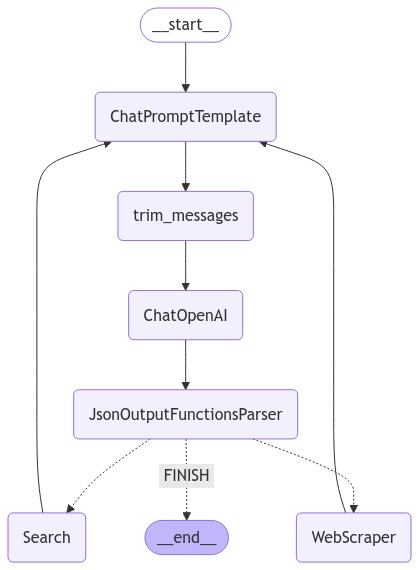

In [7]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [8]:
for s in research_chain.stream(
    "when is Taylor Swift's next tour?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content='Taylor Swift is currently on her "Eras Tour," which began in March 2023 in the U.S. and is set to run through August 2023. The tour includes U.S. stadiums and will later feature international dates. In early August, she announced additional U.S. dates for the tour in 2024, with more international dates also planned. For more specific dates and locations, you can check the official announcements and ticket outlets.', additional_kwargs={}, response_metadata={}, name='Search')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


in here, I created a doc writing team. I will remove these for our debate team

In [9]:
import operator
from pathlib import Path


# Document writing team graph state
class DocWritingState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str


# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(
    llm, tools=[write_document, edit_document, read_document]
)
# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_react_agent(llm, tools=[create_outline, read_document])
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

chart_generating_agent = create_react_agent(llm, tools=[read_document, python_repl])
context_aware_chart_generating_agent = prelude | chart_generating_agent
chart_generating_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="ChartGenerator"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

In [10]:
# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

# Add the edges that always occur
authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("ChartGenerator", "supervisor")

# Add the edges where routing applies
authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

authoring_graph.add_edge(START, "supervisor")
chain = authoring_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

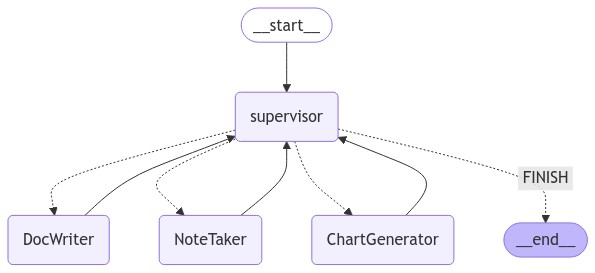

In [11]:
from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))

In [12]:
for s in authoring_chain.stream(
    "Write an outline for poem and then write the poem to disk.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='I have written the outline for the poem and saved it as "poem_outline.txt." Additionally, the poem "Whispers of the Forest" has been written and saved to "poem_whispers_of_the_forest.txt."', additional_kwargs={}, response_metadata={}, name='DocWriter')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


In [13]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)

In [14]:
# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "PaperWritingTeam", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("PaperWritingTeam", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

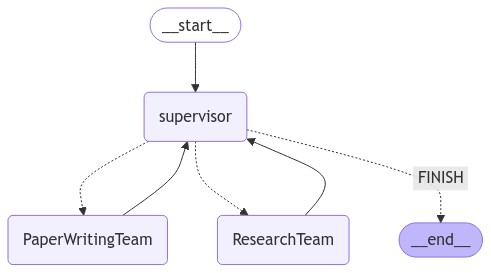

In [15]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

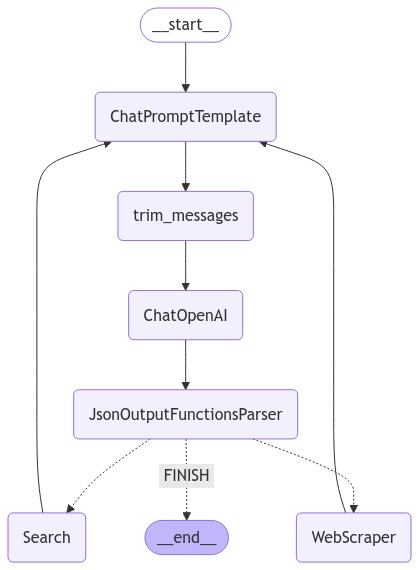

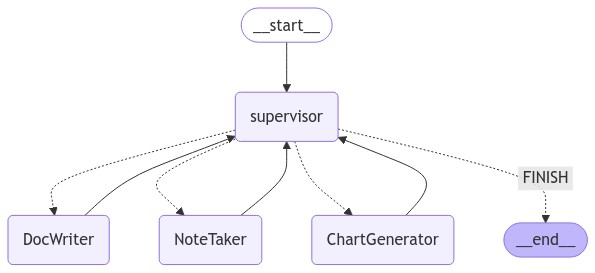

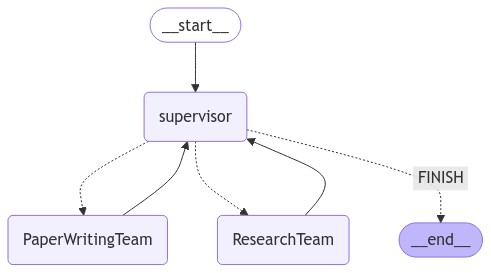

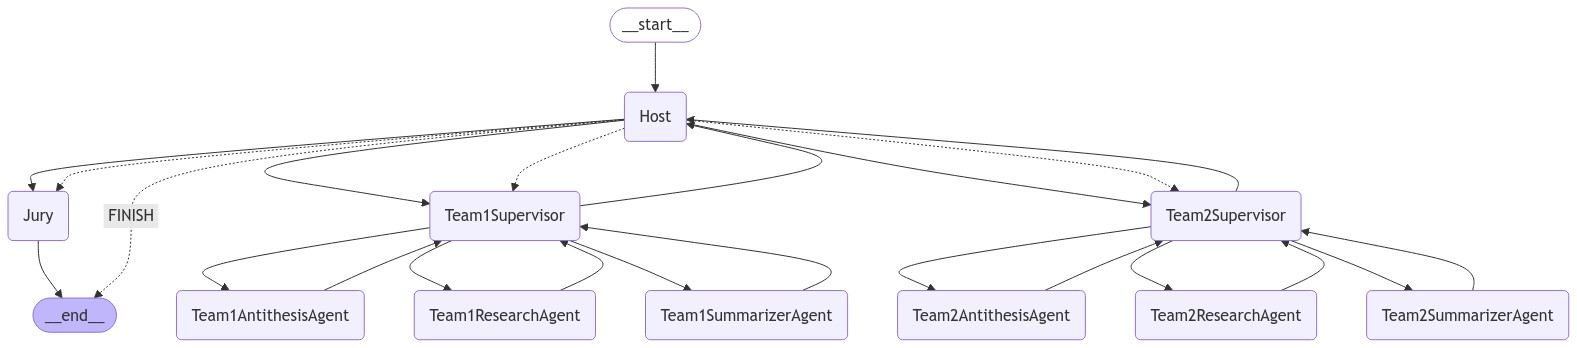

In [21]:
import getpass
import os
from dotenv import load_dotenv

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

load_dotenv()

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")


from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )


from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\'\'\'python\n{code}\n\'\'\'\nStdout: {result}"


from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, trim_messages

llm = ChatOpenAI(model="gpt-4o-mini")

trimmer = trim_messages(
    max_tokens=100000,
    strategy="last",
    token_counter=llm,
    include_system=True,
)


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | trimmer
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )


import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o")

search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_react_agent(llm, tools=[scrape_webpages])
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)


research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain


from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))



import operator
from pathlib import Path


# Document writing team graph state
class DocWritingState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str


# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(
    llm, tools=[write_document, edit_document, read_document]
)
# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_react_agent(llm, tools=[create_outline, read_document])
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

chart_generating_agent = create_react_agent(llm, tools=[read_document, python_repl])
context_aware_chart_generating_agent = prelude | chart_generating_agent
chart_generating_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="ChartGenerator"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)


# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

# Add the edges that always occur
authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("ChartGenerator", "supervisor")

# Add the edges where routing applies
authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

authoring_graph.add_edge(START, "supervisor")
chain = authoring_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)


from IPython.display import Image, display

display(Image(chain.get_graph().draw_mermaid_png()))


from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PaperWritingTeam"],
)


# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "PaperWritingTeam", get_last_message | authoring_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("PaperWritingTeam", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PaperWritingTeam": "PaperWritingTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()


from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))


# Define the state types
class DebateState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    topic: str
    team_assignments: Dict[str, str]
    current_speaker: str
    debate_stage: str
    team_responses: Dict[str, str]
    next: str

# Define the nodes
def host_node(state):
    # Logic for the host to manage the debate, including rules enforcement
    # Update debate_stage, current_speaker, and next based on the debate flow
    pass

def team_supervisor_node(state, team_name):
    # Logic for team supervisors to manage their teams and act as speakers
    pass

def research_agent_node(state, team_name):
    # Logic for research agent to gather information
    pass

def antithesis_agent_node(state, team_name):
    # Logic for antithesis agent to generate questions
    pass

def summarizer_agent_node(state, team_name):
    # Logic for summarizer agent to create concise responses
    pass

def jury_node(state):
    # Logic for the jury to evaluate the debate
    pass

# Create the graph
debate_graph = StateGraph(DebateState)

# Add nodes
debate_graph.add_node("Host", host_node)
debate_graph.add_node("Team1Supervisor", lambda s: team_supervisor_node(s, "Team1"))
debate_graph.add_node("Team2Supervisor", lambda s: team_supervisor_node(s, "Team2"))

# Add team-specific agent nodes
for team in ["Team1", "Team2"]:
    debate_graph.add_node(f"{team}ResearchAgent", lambda s: research_agent_node(s, team))
    debate_graph.add_node(f"{team}AntithesisAgent", lambda s: antithesis_agent_node(s, team))
    debate_graph.add_node(f"{team}SummarizerAgent", lambda s: summarizer_agent_node(s, team))

debate_graph.add_node("Jury", jury_node)

# Add edges
debate_graph.add_edge(START, "Host")
debate_graph.add_edge("Host", "Team1Supervisor")
debate_graph.add_edge("Host", "Team2Supervisor")

# Team preparation edges
for team in ["Team1", "Team2"]:
    supervisor = f"{team}Supervisor"
    debate_graph.add_edge(supervisor, f"{team}ResearchAgent")
    debate_graph.add_edge(supervisor, f"{team}AntithesisAgent")
    debate_graph.add_edge(supervisor, f"{team}SummarizerAgent")
    debate_graph.add_edge(f"{team}ResearchAgent", supervisor)
    debate_graph.add_edge(f"{team}AntithesisAgent", supervisor)
    debate_graph.add_edge(f"{team}SummarizerAgent", supervisor)

# Debate flow edges
debate_graph.add_edge("Team1Supervisor", "Host")
debate_graph.add_edge("Team2Supervisor", "Host")

# Final evaluation
debate_graph.add_edge("Host", "Jury")
debate_graph.add_edge("Jury", END)

# Add conditional edges for the Host to manage debate stages
debate_graph.add_conditional_edges(
    "Host",
    lambda x: x["next"],
    {
        "Team1Supervisor": "Team1Supervisor",
        "Team2Supervisor": "Team2Supervisor",
        "Jury": "Jury",
        "FINISH": END,
    }
)

# Compile the graph
debate_chain = debate_graph.compile()
from IPython.display import Image, display

display(Image(debate_chain.get_graph().draw_mermaid_png()))

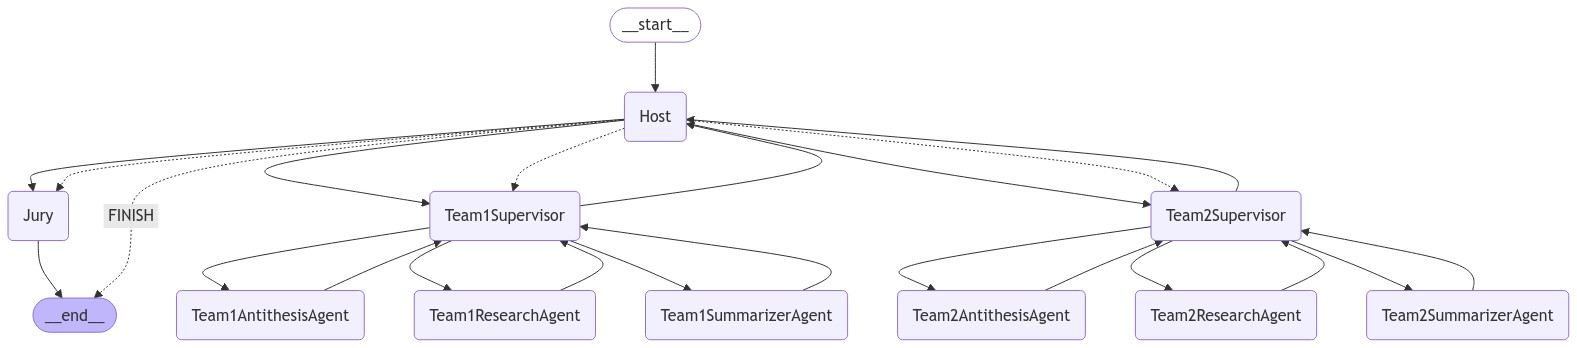

In [23]:
import getpass
import os
from dotenv import load_dotenv

from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults

from langchain_core.tools import tool
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict


from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, trim_messages


import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent

from IPython.display import Image, display

def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

load_dotenv()

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")


tavily_tool = TavilySearchResults(max_results=5)


# @tool
# def scrape_webpages(urls: List[str]) -> str:
#     """Use requests and bs4 to scrape the provided web pages for detailed information."""
#     loader = WebBaseLoader(urls)
#     docs = loader.load()
#     return "\n\n".join(
#         [
#             f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
#             for doc in docs
#         ]
#     )



# _TEMP_DIRECTORY = TemporaryDirectory()
# WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


# @tool
# def create_outline(
#     points: Annotated[List[str], "List of main points or sections."],
#     file_name: Annotated[str, "File path to save the outline."],
# ) -> Annotated[str, "Path of the saved outline file."]:
#     """Create and save an outline."""
#     with (WORKING_DIRECTORY / file_name).open("w") as file:
#         for i, point in enumerate(points):
#             file.write(f"{i + 1}. {point}\n")
#     return f"Outline saved to {file_name}"


# @tool
# def read_document(
#     file_name: Annotated[str, "File path to save the document."],
#     start: Annotated[Optional[int], "The start line. Default is 0"] = None,
#     end: Annotated[Optional[int], "The end line. Default is None"] = None,
# ) -> str:
#     """Read the specified document."""
#     with (WORKING_DIRECTORY / file_name).open("r") as file:
#         lines = file.readlines()
#     if start is not None:
#         start = 0
#     return "\n".join(lines[start:end])


# @tool
# def write_document(
#     content: Annotated[str, "Text content to be written into the document."],
#     file_name: Annotated[str, "File path to save the document."],
# ) -> Annotated[str, "Path of the saved document file."]:
#     """Create and save a text document."""
#     with (WORKING_DIRECTORY / file_name).open("w") as file:
#         file.write(content)
#     return f"Document saved to {file_name}"


# @tool
# def edit_document(
#     file_name: Annotated[str, "Path of the document to be edited."],
#     inserts: Annotated[
#         Dict[int, str],
#         "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
#     ],
# ) -> Annotated[str, "Path of the edited document file."]:
#     """Edit a document by inserting text at specific line numbers."""

#     with (WORKING_DIRECTORY / file_name).open("r") as file:
#         lines = file.readlines()

#     sorted_inserts = sorted(inserts.items())

#     for line_number, text in sorted_inserts:
#         if 1 <= line_number <= len(lines) + 1:
#             lines.insert(line_number - 1, text + "\n")
#         else:
#             return f"Error: Line number {line_number} is out of range."

#     with (WORKING_DIRECTORY / file_name).open("w") as file:
#         file.writelines(lines)

#     return f"Document edited and saved to {file_name}"


# # Warning: This executes code locally, which can be unsafe when not sandboxed

# repl = PythonREPL()


# @tool
# def python_repl(
#     code: Annotated[str, "The python code to execute to generate your chart."],
# ):
#     """Use this to execute python code. If you want to see the output of a value,
#     you should print it out with `print(...)`. This is visible to the user."""
#     try:
#         result = repl.run(code)
#     except BaseException as e:
#         return f"Failed to execute. Error: {repr(e)}"
#     return f"Successfully executed:\n\'\'\'python\n{code}\n\'\'\'\nStdout: {result}"


# llm = ChatOpenAI(model="gpt-4o-mini")

# trimmer = trim_messages(
#     max_tokens=100000,
#     strategy="last",
#     token_counter=llm,
#     include_system=True,
# )


# def agent_node(state, agent, name):
#     result = agent.invoke(state)
#     return {
#         "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
#     }


# def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
#     """An LLM-based router."""
#     options = ["FINISH"] + members
#     function_def = {
#         "name": "route",
#         "description": "Select the next role.",
#         "parameters": {
#             "title": "routeSchema",
#             "type": "object",
#             "properties": {
#                 "next": {
#                     "title": "Next",
#                     "anyOf": [
#                         {"enum": options},
#                     ],
#                 },
#             },
#             "required": ["next"],
#         },
#     }
#     prompt = ChatPromptTemplate.from_messages(
#         [
#             ("system", system_prompt),
#             MessagesPlaceholder(variable_name="messages"),
#             (
#                 "system",
#                 "Given the conversation above, who should act next?"
#                 " Or should we FINISH? Select one of: {options}",
#             ),
#         ]
#     ).partial(options=str(options), team_members=", ".join(members))
#     return (
#         prompt
#         | trimmer
#         | llm.bind_functions(functions=[function_def], function_call="route")
#         | JsonOutputFunctionsParser()
#     )


# # ResearchTeam graph state
# class ResearchTeamState(TypedDict):
#     # A message is added after each team member finishes
#     messages: Annotated[List[BaseMessage], operator.add]
#     # The team members are tracked so they are aware of
#     # the others' skill-sets
#     team_members: List[str]
#     # Used to route work. The supervisor calls a function
#     # that will update this every time it makes a decision
#     next: str


# llm = ChatOpenAI(model="gpt-4o")

# search_agent = create_react_agent(llm, tools=[tavily_tool])
# search_node = functools.partial(agent_node, agent=search_agent, name="Search")

# research_agent = create_react_agent(llm, tools=[scrape_webpages])
# research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

# supervisor_agent = create_team_supervisor(
#     llm,
#     "You are a supervisor tasked with managing a conversation between the"
#     " following workers:  Search, WebScraper. Given the following user request,"
#     " respond with the worker to act next. Each worker will perform a"
#     " task and respond with their results and status. When finished,"
#     " respond with FINISH.",
#     ["Search", "WebScraper"],
# )


# research_graph = StateGraph(ResearchTeamState)
# research_graph.add_node("Search", search_node)
# research_graph.add_node("WebScraper", research_node)
# research_graph.add_node("supervisor", supervisor_agent)

# # Define the control flow
# research_graph.add_edge("Search", "supervisor")
# research_graph.add_edge("WebScraper", "supervisor")
# research_graph.add_conditional_edges(
#     "supervisor",
#     lambda x: x["next"],
#     {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
# )


# research_graph.add_edge(START, "supervisor")
# chain = research_graph.compile()


# # The following functions interoperate between the top level graph state
# # and the state of the research sub-graph
# # this makes it so that the states of each graph don't get intermixed
# def enter_chain(message: str):
#     results = {
#         "messages": [HumanMessage(content=message)],
#     }
#     return results


# research_chain = enter_chain | chain



# display(Image(chain.get_graph(xray=True).draw_mermaid_png()))



# import operator
# from pathlib import Path


# # Document writing team graph state
# class DocWritingState(TypedDict):
#     # This tracks the team's conversation internally
#     messages: Annotated[List[BaseMessage], operator.add]
#     # This provides each worker with context on the others' skill sets
#     team_members: str
#     # This is how the supervisor tells langgraph who to work next
#     next: str
#     # This tracks the shared directory state
#     current_files: str


# # This will be run before each worker agent begins work
# # It makes it so they are more aware of the current state
# # of the working directory.
# def prelude(state):
#     written_files = []
#     if not WORKING_DIRECTORY.exists():
#         WORKING_DIRECTORY.mkdir()
#     try:
#         written_files = [
#             f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
#         ]
#     except Exception:
#         pass
#     if not written_files:
#         return {**state, "current_files": "No files written."}
#     return {
#         **state,
#         "current_files": "\nBelow are files your team has written to the directory:\n"
#         + "\n".join([f" - {f}" for f in written_files]),
#     }


# llm = ChatOpenAI(model="gpt-4o")

# doc_writer_agent = create_react_agent(
#     llm, tools=[write_document, edit_document, read_document]
# )
# # Injects current directory working state before each call
# context_aware_doc_writer_agent = prelude | doc_writer_agent
# doc_writing_node = functools.partial(
#     agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
# )

# note_taking_agent = create_react_agent(llm, tools=[create_outline, read_document])
# context_aware_note_taking_agent = prelude | note_taking_agent
# note_taking_node = functools.partial(
#     agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
# )

# chart_generating_agent = create_react_agent(llm, tools=[read_document, python_repl])
# context_aware_chart_generating_agent = prelude | chart_generating_agent
# chart_generating_node = functools.partial(
#     agent_node, agent=context_aware_note_taking_agent, name="ChartGenerator"
# )

# doc_writing_supervisor = create_team_supervisor(
#     llm,
#     "You are a supervisor tasked with managing a conversation between the"
#     " following workers:  {team_members}. Given the following user request,"
#     " respond with the worker to act next. Each worker will perform a"
#     " task and respond with their results and status. When finished,"
#     " respond with FINISH.",
#     ["DocWriter", "NoteTaker", "ChartGenerator"],
# )


# # Create the graph here:
# # Note that we have unrolled the loop for the sake of this doc
# authoring_graph = StateGraph(DocWritingState)
# authoring_graph.add_node("DocWriter", doc_writing_node)
# authoring_graph.add_node("NoteTaker", note_taking_node)
# authoring_graph.add_node("ChartGenerator", chart_generating_node)
# authoring_graph.add_node("supervisor", doc_writing_supervisor)

# # Add the edges that always occur
# authoring_graph.add_edge("DocWriter", "supervisor")
# authoring_graph.add_edge("NoteTaker", "supervisor")
# authoring_graph.add_edge("ChartGenerator", "supervisor")

# # Add the edges where routing applies
# authoring_graph.add_conditional_edges(
#     "supervisor",
#     lambda x: x["next"],
#     {
#         "DocWriter": "DocWriter",
#         "NoteTaker": "NoteTaker",
#         "ChartGenerator": "ChartGenerator",
#         "FINISH": END,
#     },
# )

# authoring_graph.add_edge(START, "supervisor")
# chain = authoring_graph.compile()


# # The following functions interoperate between the top level graph state
# # and the state of the research sub-graph
# # this makes it so that the states of each graph don't get intermixed
# def enter_chain(message: str, members: List[str]):
#     results = {
#         "messages": [HumanMessage(content=message)],
#         "team_members": ", ".join(members),
#     }
#     return results


# # We reuse the enter/exit functions to wrap the graph
# authoring_chain = (
#     functools.partial(enter_chain, members=authoring_graph.nodes)
#     | authoring_graph.compile()
# )


# display(Image(chain.get_graph().draw_mermaid_png()))


# llm = ChatOpenAI(model="gpt-4o")

# supervisor_node = create_team_supervisor(
#     llm,
#     "You are a supervisor tasked with managing a conversation between the"
#     " following teams: {team_members}. Given the following user request,"
#     " respond with the worker to act next. Each worker will perform a"
#     " task and respond with their results and status. When finished,"
#     " respond with FINISH.",
#     ["ResearchTeam", "PaperWritingTeam"],
# )


# # Top-level graph state
# class State(TypedDict):
#     messages: Annotated[List[BaseMessage], operator.add]
#     next: str


# def get_last_message(state: State) -> str:
#     return state["messages"][-1].content


# def join_graph(response: dict):
#     return {"messages": [response["messages"][-1]]}


# # Define the graph.
# super_graph = StateGraph(State)
# # First add the nodes, which will do the work
# super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
# super_graph.add_node(
#     "PaperWritingTeam", get_last_message | authoring_chain | join_graph
# )
# super_graph.add_node("supervisor", supervisor_node)

# # Define the graph connections, which controls how the logic
# # propagates through the program
# super_graph.add_edge("ResearchTeam", "supervisor")
# super_graph.add_edge("PaperWritingTeam", "supervisor")
# super_graph.add_conditional_edges(
#     "supervisor",
#     lambda x: x["next"],
#     {
#         "PaperWritingTeam": "PaperWritingTeam",
#         "ResearchTeam": "ResearchTeam",
#         "FINISH": END,
#     },
# )
# super_graph.add_edge(START, "supervisor")
# super_graph = super_graph.compile()

# display(Image(super_graph.get_graph().draw_mermaid_png()))


# Define the state types
class DebateState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    topic: str
    team_assignments: Dict[str, str]
    current_speaker: str
    debate_stage: str
    team_responses: Dict[str, str]
    next: str

# Define the nodes
def host_node(state):
    # Logic for the host to manage the debate, including rules enforcement
    # Update debate_stage, current_speaker, and next based on the debate flow
    pass

def team_supervisor_node(state, team_name):
    # Logic for team supervisors to manage their teams and act as speakers
    pass

def research_agent_node(state, team_name):
    # Logic for research agent to gather information
    pass

def antithesis_agent_node(state, team_name):
    # Logic for antithesis agent to generate questions
    pass

def summarizer_agent_node(state, team_name):
    # Logic for summarizer agent to create concise responses
    pass

def jury_node(state):
    # Logic for the jury to evaluate the debate
    pass

# Create the graph
debate_graph = StateGraph(DebateState)

# Add nodes
debate_graph.add_node("Host", host_node)
debate_graph.add_node("Team1Supervisor", lambda s: team_supervisor_node(s, "Team1"))
debate_graph.add_node("Team2Supervisor", lambda s: team_supervisor_node(s, "Team2"))

# Add team-specific agent nodes
for team in ["Team1", "Team2"]:
    debate_graph.add_node(f"{team}ResearchAgent", lambda s: research_agent_node(s, team))
    debate_graph.add_node(f"{team}AntithesisAgent", lambda s: antithesis_agent_node(s, team))
    debate_graph.add_node(f"{team}SummarizerAgent", lambda s: summarizer_agent_node(s, team))

debate_graph.add_node("Jury", jury_node)

# Add edges
debate_graph.add_edge(START, "Host")
debate_graph.add_edge("Host", "Team1Supervisor")
debate_graph.add_edge("Host", "Team2Supervisor")

# Team preparation edges
for team in ["Team1", "Team2"]:
    supervisor = f"{team}Supervisor"
    debate_graph.add_edge(supervisor, f"{team}ResearchAgent")
    debate_graph.add_edge(supervisor, f"{team}AntithesisAgent")
    debate_graph.add_edge(supervisor, f"{team}SummarizerAgent")
    debate_graph.add_edge(f"{team}ResearchAgent", supervisor)
    debate_graph.add_edge(f"{team}AntithesisAgent", supervisor)
    debate_graph.add_edge(f"{team}SummarizerAgent", supervisor)

# Debate flow edges
debate_graph.add_edge("Team1Supervisor", "Host")
debate_graph.add_edge("Team2Supervisor", "Host")

# Final evaluation
debate_graph.add_edge("Host", "Jury")
debate_graph.add_edge("Jury", END)

# Add conditional edges for the Host to manage debate stages
debate_graph.add_conditional_edges(
    "Host",
    lambda x: x["next"],
    {
        "Team1Supervisor": "Team1Supervisor",
        "Team2Supervisor": "Team2Supervisor",
        "Jury": "Jury",
        "FINISH": END,
    }
)

# Compile the graph
debate_chain = debate_graph.compile()
from IPython.display import Image, display

display(Image(debate_chain.get_graph().draw_mermaid_png()))